# Use Gensim to vectorize features2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import numexpr as ne
import mskcc_functions as ski
import scipy.stats as scs
import feature_engineering as fe
import xgboost as xgb

from xgboost import plot_importance
from pprint import pprint
from matplotlib  import cm
from collections import Counter
from importlib import reload
from gensim import corpora, matutils, models, similarities
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

sns.set_context("paper")
%matplotlib inline

Using TensorFlow backend.
/usr/lib64/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
Slow version of gensim.models.doc2vec is being used


In [2]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])

<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<ipython-input-2-4467bb76c423>:2: DeprecationWarning: invalid escape sequence \|
  text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',


In [3]:
feature_words1= pd.read_csv('./data/features_pass1.csv', header=None)
feature_words1 = list(feature_words1[0])
feature_words2 = list(set(class_train['Gene']))
feature_words = feature_words1 + feature_words2
print(len(feature_words))

24223


In [4]:
my_dict = corpora.Dictionary([feature_words])

In [5]:
%%time
documents = []
tokenized_documents = []
for i in range(len(text_train)):
    doc= text_train['Text'].iloc[i]
    tokenized_doc = word_tokenize(fe.replace_with_whitespace(doc, hyphens='on'))
    
    documents.append(doc)
    tokenized_documents.append(tokenized_doc)

print(len(documents))     # double checking length
print(len(tokenized_documents))     # double checking length

3321
3321
CPU times: user 1min 52s, sys: 540 ms, total: 1min 53s
Wall time: 1min 53s


In [6]:
%time
corpus = [my_dict.doc2bow(token) for token in tokenized_documents]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [7]:
#feature_matrix = matutils.corpus2dense(corpus_tfidf, num_terms=len(feature_words), num_docs=len(corpus_tfidf)).T
#feat_mat = pd.DataFrame(feature_matrix)
#feat_mat.to_csv('./data/feature_matrix_pass1_TfIdf.csv', index=False)

In [8]:
%%time
# LSI transform
lsi_model = models.LsiModel(corpus_tfidf, id2word=my_dict, num_topics=500)
corpus_lsi = lsi_model[corpus_tfidf]

CPU times: user 13.7 s, sys: 314 ms, total: 14 s
Wall time: 14 s


In [9]:
lsi_matrix = matutils.corpus2dense(corpus_lsi, num_terms=len(feature_words), num_docs=len(corpus_lsi)).T
lsi_feat_mat = pd.DataFrame(lsi_matrix)
lsi_feat_mat.to_csv('./data/feature_matrix_pass1_LSI.csv', index=False)

In [10]:
%%time
# LDA transform
lda_model = models.LdaModel(corpus_tfidf, id2word=my_dict, num_topics=300)
corpus_lda = lda_model[corpus_tfidf]

CPU times: user 1min 34s, sys: 429 ms, total: 1min 35s
Wall time: 1min 35s


In [11]:
lda_matrix = matutils.corpus2dense(corpus_lda, num_terms=len(feature_words), num_docs=len(corpus_lda)).T
lda_feat_mat = pd.DataFrame(lda_matrix)
lda_feat_mat.to_csv('./data/feature_matrix_pass1_LDA.csv', index=False)

In [12]:
print(lsi_feat_mat.shape)
print(lda_feat_mat.shape)

(3321, 24223)
(3321, 24223)


Create feature matrix lsiX and ldaX for classifications

In [13]:
# Import Data and extract gene and mutation type info
# Get Gene feature from 'train_variants' data
X_gene = np.array(class_train.Gene)
X_gene_int = LabelEncoder().fit_transform(X_gene.ravel()).reshape(-1, 1)
X_gene_bin = OneHotEncoder().fit_transform(X_gene_int).toarray()
gene_table = pd.DataFrame(X_gene_bin)

# Get Mutation Type from 'train_variants' data
mut_type = ski.convert_mutation_type(class_train)
X_mtype = np.array(mut_type['mutation_type'])
X_mtype_int = LabelEncoder().fit_transform(X_mtype.ravel()).reshape(-1, 1)
X_mtype_bin = OneHotEncoder().fit_transform(X_mtype_int).toarray()
mtype_table = pd.DataFrame(X_mtype_bin)

In [14]:
lsi_features = pd.concat([gene_table, mtype_table, lsi_feat_mat], axis=1)
print('LSI Features Shape', lsi_features.shape)

lda_features = pd.concat([gene_table, mtype_table, lda_feat_mat], axis=1)
print('LDA Features Shape', lsi_features.shape)

LSI Features Shape (3321, 24504)
LDA Features Shape (3321, 24504)


In [15]:
lsiX = np.array(lsi_features).astype(float)
ldaX = np.array(lda_features).astype(float)
y = np.array(class_train.Class).astype(int).ravel()

<b>Check with PCA</b>

LSI

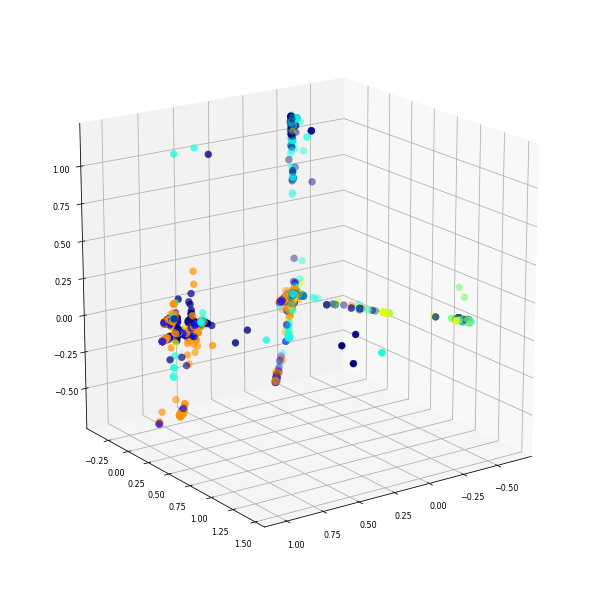

In [16]:
# Create a new table with ID as index
pca_lsi = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(lsiX)
pca_lsi['x'] = pca.fit_transform(lsiX).T[0]
pca_lsi['y'] = pca.fit_transform(lsiX).T[1]
pca_lsi['z'] = pca.fit_transform(lsiX).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_lsi.x, pca_lsi.y, pca_lsi.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

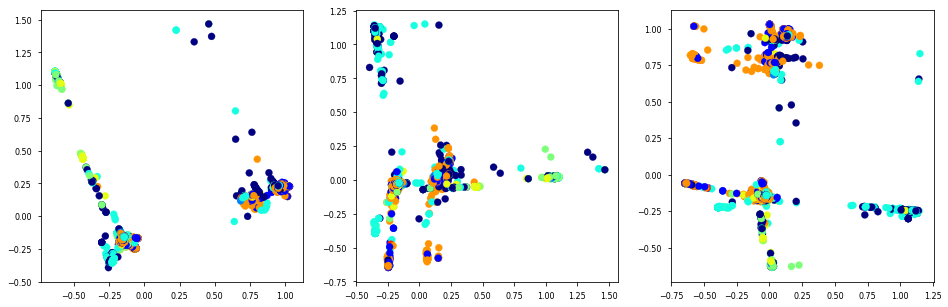

In [17]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_lsi.x, pca_lsi.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_lsi.y, pca_lsi.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_lsi.z, pca_lsi.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

LDA

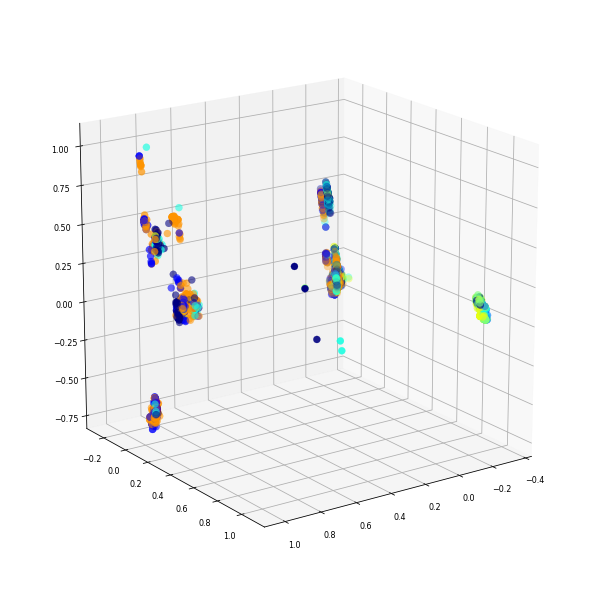

In [18]:
# Create a new table with ID as index
pca_lda = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(ldaX)
pca_lda['x'] = pca.fit_transform(ldaX).T[0]
pca_lda['y'] = pca.fit_transform(ldaX).T[1]
pca_lda['z'] = pca.fit_transform(ldaX).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_lda.x, pca_lda.y, pca_lda.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

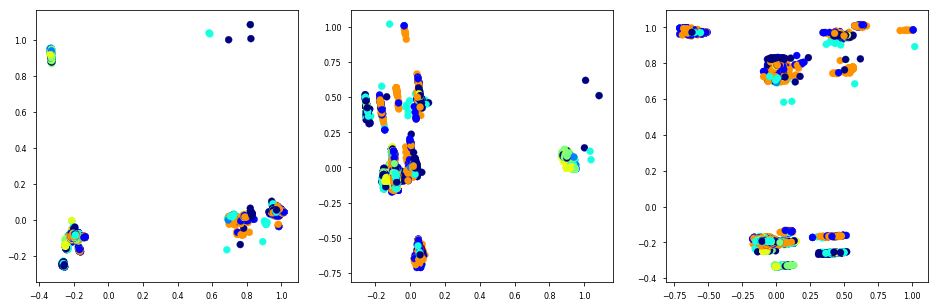

In [19]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_lda.x, pca_lda.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_lda.y, pca_lda.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_lda.z, pca_lda.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

<b>RFC</b>

In [20]:
%%time
# Run RFC on the data
labels = ['LSI', 'LDA']
Xs = [lsiX, ldaX]

for i in range(2):
    X_train, X_test, y_train, y_test = train_test_split(Xs[i], y, test_size=0.15)
    
    rfc = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=4)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_proba = rfc.predict_proba(X_test)
    print('%s accuracy: %f' % (labels[i], accuracy_score(y_test, y_pred)))
    print('%s log loss: %f' % (labels[i], log_loss(y_test, y_proba, labels=list(range(1, 10)))))

LSI accuracy: 0.631263
LSI log loss: 1.392349
LDA accuracy: 0.667335
LDA log loss: 1.001369
CPU times: user 44 s, sys: 792 ms, total: 44.8 s
Wall time: 14.1 s


In [21]:
lda_feature_importances = rfc.feature_importances_
lda_nonzero_feat_imp = list(np.argwhere(lda_feature_importances > 0).ravel())
ldaX1 = ldaX[:, lda_nonzero_feat_imp]
print(ldaX.shape)
print(ldaX1.shape)

(3321, 24504)
(3321, 552)


<b>XGBoost with LDA</b>

========== Iteration 1/1 ==========
[0]	train-mlogloss:2.10439	valid-mlogloss:2.11991
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[50]	train-mlogloss:0.62849	valid-mlogloss:1.1429
[100]	train-mlogloss:0.455926	valid-mlogloss:1.10366
[150]	train-mlogloss:0.446779	valid-mlogloss:1.1023
Stopping. Best iteration:
[108]	train-mlogloss:0.450543	valid-mlogloss:1.10158

Average mlogloss: 1.101577
CPU times: user 3min 9s, sys: 46.1 ms, total: 3min 9s
Wall time: 32.4 s


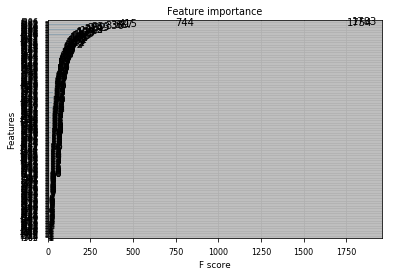

In [22]:
%%time
# Adjust the class labels so it starts with 0
y_adj = y-1

scores = []

iteration = 1
for i in range(iteration):
    print('========== Iteration %d/%d ==========' % (i+1, iteration))
    
    # Split into test and train randomly, every iteration
    x1, x2, y1, y2 = train_test_split(ldaX1, y_adj, test_size=0.15)
    
    # Set up parameters for xgboost
    params = {
            'eta': 0.1,
            'gamma': 0.8,
            'max_delta_step': 1,
            'max_depth': 12,
            'min_child_weight': 1,
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'num_class': 9,
            'seed': 1,
            'silent': True,
            'nthread' :6
            }

    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

    model = xgb.train(params, xgb.DMatrix(x1, y1), 500,  watchlist, 
                      verbose_eval=50, early_stopping_rounds=50)

    score = log_loss(y2, model.predict(xgb.DMatrix(x2), 
                     ntree_limit=model.best_ntree_limit), 
                     labels = list(range(9)))
    scores.append(score)
    #print(score)
          
print("Average mlogloss: %f" % np.mean(scores))
plot_importance(model)

In [23]:
fscores = pd.DataFrame([val for val in model.get_fscore().values()])
fscores.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9]).astype(int)

,0
count,303
mean,53
std,157
min,1
25%,8
50%,20
75%,46
80%,56
90%,107
max,1783
